In [69]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Oct  7 15:53:21 2016

@author: dean
"""

import matplotlib.pyplot as plt 
import numpy as np
from itertools import product
import matplotlib.gridspec as gridspec
import pandas as pd

def naked_plot(axes):
    for ax in  axes:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        
def fit_axis(ax, x, y, x_ax=True, y_ax=True, unity_ax=False):
    maxest = max([max(x), max(y)])
    minest = min([min(x), min(y)])
    if unity_ax:
        ax.plot([minest,maxest],[minest,maxest], lw=0.1, color='k');
    if min(y)<0:
        ax.plot([min(x),max(x)],[0,0], lw=.3, color='k');
    if min(x)<0:
        ax.plot([0,0],[min(y),max(y)], lw=.3, color='k');

def simple_hist_pd(ax, var, orientation='vertical', fontsize=10):
    n = ax.hist(var,histtype='step', align='mid',lw=0.5, 
                bins='auto', orientation=orientation)[0]
    sigfig = 4
    naked_plot([ax,])
    the_range = [min(var), max(var)]
    if orientation[0]=='v':  
        ax.set_ylim(0, max(n)+max(n)*.15)
        ax.set_xlim(the_range)
        ax.text(np.max(var), -ax.get_ylim()[1]/10, np.round(np.max(var),sigfig),ha='right',va='top', fontsize=fontsize )
        ax.text(np.min(var), -ax.get_ylim()[1]/10, np.round(np.min(var),sigfig),  ha='left',va='top', fontsize=fontsize)
        spine_loc = 'bottom'
    else:
        ax.set_xlim(0, max(n)+max(n)*.15)
        ax.set_ylim(the_range)
        ax.text(-ax.get_xlim()[1]/10, np.max(var), np.round(np.max(var), sigfig),  ha='right',va='top', fontsize=fontsize )
        ax.text(-ax.get_xlim()[1]/10, np.min(var), np.round(np.min(var), sigfig),  ha='right',va='bottom', fontsize=fontsize)
        spine_loc = 'left'
    ax.spines[spine_loc].set_visible(True)
    ax.spines[spine_loc].set(lw=0.5)
    ax.spines[spine_loc].set_bounds(the_range[0], the_range[1])
    
def small_mult_scatter_w_marg_pd(x, y):
    m = y.shape[1]+1
    n = x.shape[1]+1
    left_bottom = m*n-n
    y_hist_pos = list(range(0, m*n, n))[:-1]
    x_hist_pos = list(range(left_bottom+1, m*n))
    
    scatter_inds = list(set(range(m*n)) - (set(x_hist_pos) | set(y_hist_pos) | set([left_bottom,])))
    cart_inds = list(product(range(m-1), range(n-1)))
    
    gs = gridspec.GridSpec(m, n, width_ratios=[1,]+[8,]*(n-1),
                            height_ratios=[8,]*(m-1)+[1,])
    
    plt.figure(figsize=(n*2,m*2))
    fontsize=10
    y_hists = []
    for y_col, pos in zip(y, y_hist_pos):
        _=plt.subplot(gs[pos])
        simple_hist_pd(_, y[y_col], orientation='horizontal')
        _.set_ylabel(str(y_col), rotation='horizontal', 
                     labelpad=fontsize*3, fontsize=fontsize)
        y_hists.append(_)
    x_hists = []
    
    for x_col, pos in zip(x, x_hist_pos):
        _ = plt.subplot(gs[pos])
        simple_hist_pd(_, x[x_col])
        _.set_xlabel(str(x_col), rotation='horizontal', 
                      fontsize=fontsize, labelpad=fontsize*2)
        x_hists.append(_)
    
    scatters = []    
    for (y_ind, x_ind), pos in zip(cart_inds, scatter_inds):
        _ = plt.subplot(gs[pos], sharex= x_hists[x_ind], sharey=y_hists[y_ind])
        _.scatter(x.iloc[:, x_ind], y.iloc[:, y_ind], s=0.4)
        fit_axis(_, x.iloc[:, x_ind], y.iloc[:, y_ind])
        scatters.append(_)
          
    naked_plot(scatters)
    
    return scatters, x_hists, y_hists
n=100
d = np.random.normal(size=(n,3))
df1 = pd.DataFrame(d, columns=['a','b', 'c'])
d =np.random.normal(size=(n,1))
df2 = pd.DataFrame(d, columns=['a'])




A linear model typically takes the form:

$$ y = X \beta + \epsilon$$

* $y$ is the data which here is assumed to be a linear function of the colums of $X$.
* $B$ is the vector of coeffecients that specify this function.
* $\epsilon$ is typically independent and identically distributed guassian noise,  independent of $y$.

In evaluating a fit we can check these assumptions, by making plots of diagnostic quantities for which normative values are well known.

<h4>Plotting the fit.</h4>
The first thing to do is plot the scatter of the fit.


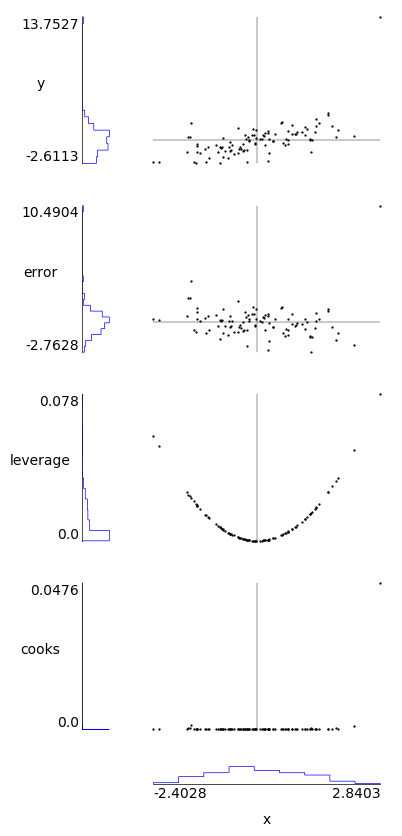

In [75]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
n = 100
outlier = np.zeros((n,1))

x = np.random.normal(size=(n,1))
x -= np.mean(x)
outlier[np.argmax(x)]=10
y = x + np.random.normal(size=(n,1)) + outlier
y -= np.mean(y)


b, res, rank, s = np.linalg.lstsq(x, y)

y_hat = np.dot(x, b)
e = y-y_hat
#print(((sum(y_hat**2)/sum(y**2))**0.5)[0])
#print(np.corrcoef(y.T, y_hat.T)[1,0])


inv_cov = np.linalg.inv(np.dot(x.T, x))
H = np.dot(np.dot(x, inv_cov), x.T)
h = np.expand_dims(H[np.diag_indices_from(H)],1)

d = ((e**2) / (sum(e**2))*(h/((1-h)**2)))


df1 = pd.DataFrame(x,columns=['x'])
df2 = pd.DataFrame(np.concatenate([y, e, h, d],1),
                   columns=['y', 'error', 'leverage', 'cooks'])
scatters, x_hists, y_hists = small_mult_scatter_w_marg_pd(df1, df2)
